Music Synchronization과 관련된 응용 등을 다룬다.

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import librosa, librosa.display
import pandas as pd
from scipy import signal
from scipy.interpolate import interp1d
import scipy.ndimage.filters
import IPython.display as ipd

# Tempo Curve

- 음악가는 지속적으로 변화하는 템포, 다이나믹 및 아티큘레이션을 통해 음악 작품에 터치한다. 기계적으로 연주하는 대신 어떤 부분에서는 속도를 높이고 다른 부분에서는 속도를 줄여 음악을 만든다. 마찬가지로 사운드 강도를 지속적으로 변경하고 특정 음을 강조한다. 이러한 연주 측면은 음악을 이해하고 인식하는 데 근본적으로 중요하다.


- **퍼포먼스 분석(performace analysis)** 이라고도 하는 다양한 연주(interpretation)의 자동 분석은 활발한 연구 분야이다. 일반적으로 두 가지 보완적인 목표를 구분해 볼 수 있다. 
    - 첫 번째 목표는 일반적인 퍼포먼스 규칙의 파생을 허용하는 서로 다른 연주 간의 공통점을 찾는 것이다. 예를 들어, 대부분의 음악가가 음악이 끝날 때 점차 속도를 늦추어 작품을 끝내는 규칙 같은 것이 있을 수 있다. 
    - 두 번째로 더 어려운 목표는 특정 연주자의 스타일에 대해 정확히 어떤 특징이 있는지 파악하는 것이다. 예를 들어 Karajan이 특별한 이유는 무엇일까? 그리고 그의 연주는 다른 지휘자의 녹음과 어떻게 다른가?

- 특정 연주를 분석하기 전에, 음악의 음표가 실제로 연주되는 시기와 방법에 대한 정보가 필요하다. 따라서 연주 분석의 첫 번째 단계로 다양한 음표 이벤트의 정확한 타이밍과 강도를 명시하는 적절한 속성을 사용하여 연주에 주석을 달아야 한다. 오디오 녹음에서 이러한 성능 속성을 추출하는 것은 어려운 문제이다. 많은 연구자들이 오디오 스트림에서 두드러진 데이터 포인트를 표시하여 오디오 자료에 수동으로 주석을 단다. 그러나 매우 노동 집약적인 이러한 수동의 과정은 대량의 오디오 컬렉션을 고려할 때 엄두도 내지 못할 것이다.

## 템포 곡선(Tempo Curve) 계산: 기본 개념

- 챕터에서 다루었던 Music Synchronization 기법을 사용하여 템포 관련 정보를 도출하는 접근 방식을 보기로 한다. 서양 고전 음악의 많은 작품은 악보를 기반으로 한다. 기본 아이디어는 연주된 버전을 비교할 수 있는 참조 버전(비트(beat) 위치가 알려진 것으로 가정됨)으로 이 악보를 사용하는 것이다.
    * 첫째, **참조 버전(reference version)** 은 피아노-롤 표현으로 변환되며, 여기에서 음표는 순전히 기계적인 방식으로 알려진 일정한 템포로 연주된다.
    * 그런 다음 music synchronization 기술을 사용하여 레퍼런스의 음표 및 비트 이벤트를 주어진 연주 오디오 버전에서 해당 물리적 발생에 따라 시간순으로 정렬한다.
    * 결과의 워핑 경로는 실제 연주와 중립적인 참조 버전 간의 **상대적 템포 차이**를 나타낸다. 참조 버전의 절대 템포를 알면 워핑 경로의 기울기에서 특정 위치에서 수행된 버전의 템포를 파생할 수 있다.

- 보다 정확하게는 템포 값을 도출하기 위해서는 일정 기간 동안 연주된 버전을 "관찰"해야 한다. 이를 위해 적절한 시간 윈도우(예: 1비트 간격)을 고정한다. 
- 워핑 경로에서 수행된 버전의 해당 물리적 기간(초 단위)을 읽을 수 있다. 여기에서 시간 윈도우에 대한 **BPM(beats per minute)**(BPM)에 지정된 평균 템포 값을 도출할 수 있다. 

- 다음의 예를 보면, 한 비트의 지속 시간을 갖는 기준 시간 축에 윈도우를 고정한다. 이 예에서 참조 버전의 첫 번째 비트는 2초 동안 지속되는 연주된 버전의 섹션에 정렬된다. 
- 즉, 연주된 버전은 이 섹션에서 2초당 1비트의 평균 템포를 가지며 결과적으로 $30~\mathrm{BPM}$이 된다. 마찬가지로 두 번째 비트는 $60~\mathrm{BPM}$에 해당하는 1초 동안 지속되고 세 번째 비트는 $150~\mathrm{BPM}$에 해당하는 $0.4$초 동안 지속되며 네 번째 및 다섯 번째 비트는 $200~\mathrm{BPM}$에 해당하는 0.3초 동안 지속된다. 
- 이렇게 하면 참조 버전의 각 비트 간격에 대해 연주된 버전에 대한 **템포 곡선**이 생성된다.

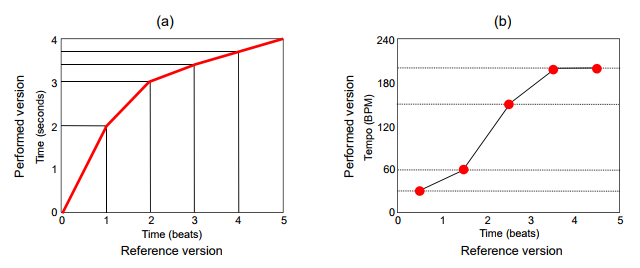

In [11]:
ipd.Image("../img/4.music_synchronization/f.4.23.PNG", width=600)

디테일을 보려면 아래의 출처 사이트를 참고하길 바람

출처 : https://www.audiolabs-erlangen.de/resources/MIR/FMP/C3/C3S3_MusicAppTempoCurve.html

# 크기(magnitude) 스케일링

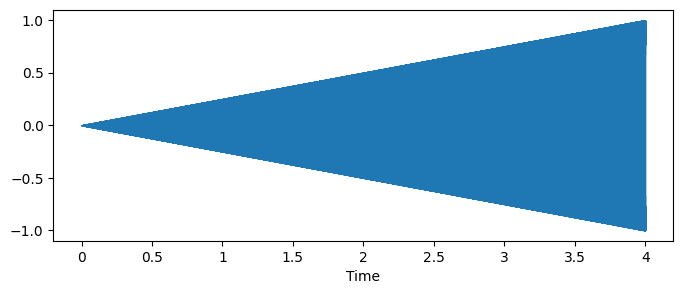

In [27]:
# 신호 생성
T = 4.0      # duration in seconds
sr = 22050   # sampling rate in Hertz
t = np.linspace(0, T, int(T*sr), endpoint=False)

# amplitude that grows linearly
amplitude = np.linspace(0, 1, int(T*sr), endpoint=False) # time-varying amplitude
x = amplitude*np.sin(2*np.pi*440*t)

ipd.display(ipd.Audio(x, rate=sr))
plt.figure(figsize=(8,3))
librosa.display.waveshow(x, sr=sr)
plt.show()

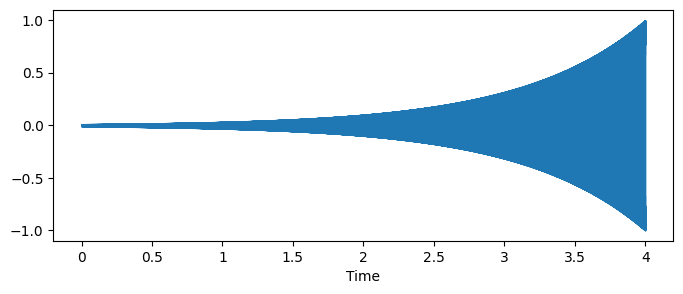

In [28]:
# amplitude that grows exponentially
amplitude = np.logspace(-2, 0, int(T*sr), endpoint=False, base=10.0)
x = amplitude*np.sin(2*np.pi*440*t)

ipd.display(ipd.Audio(x, rate=sr))
plt.figure(figsize=(8,3))
librosa.display.waveshow(x, sr=sr)
plt.show()

- 진폭이 기하급수적으로 증가하더라도 라우드니스의 증가는 점진적으로 지각된다. 이 현상은 Weber-Fechner 법칙(https://en.wikipedia.org/wiki/Weber%E2%80%93Fechner_law)의 한 예이다.

## Spectrogram Visualization

In [31]:
x, sr = librosa.load('../audio/prelude_cmaj.wav', duration=8)
ipd.Audio(x, rate=sr)

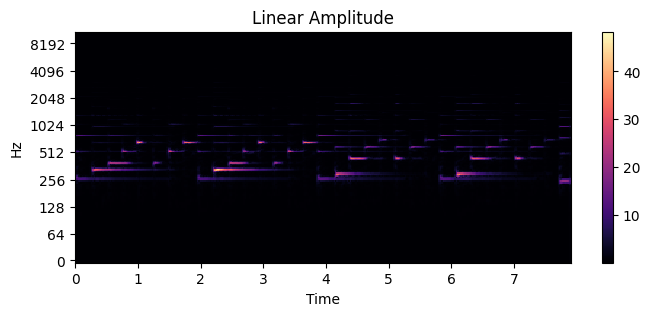

In [35]:
X = librosa.stft(x)
Xmag = abs(X)
plt.figure(figsize=(8,3))
plt.title('Linear Amplitude')
librosa.display.specshow(Xmag, sr=sr, x_axis='time', y_axis='log')
plt.colorbar()
plt.show()

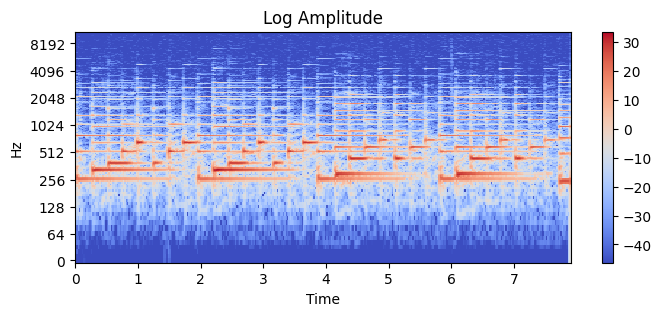

In [36]:
Xdb = librosa.amplitude_to_db(Xmag)
plt.figure(figsize=(8,3))
plt.title('Log Amplitude')
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
plt.colorbar()
plt.show()

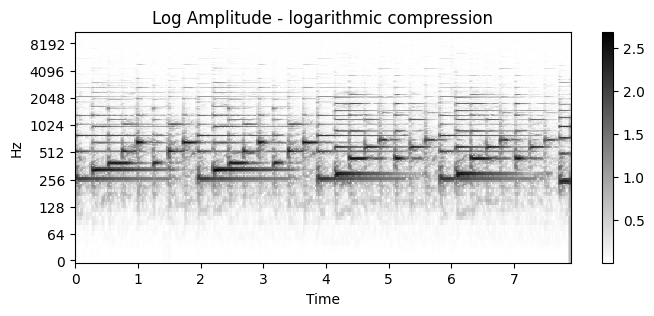

In [38]:
Xmag = np.log10(1+10*abs(X))
plt.figure(figsize=(8,3))
plt.title('Log Amplitude - logarithmic compression')
librosa.display.specshow(Xmag, sr=sr, x_axis='time', y_axis='log', cmap="gray_r")
plt.colorbar()
plt.show()

C:\Users\JHCho\anaconda3\envs\mir\lib\site-packages\librosa\core\convert.py:1332: RuntimeWarning: divide by zero encountered in log10
  + 2 * np.log10(f_sq)


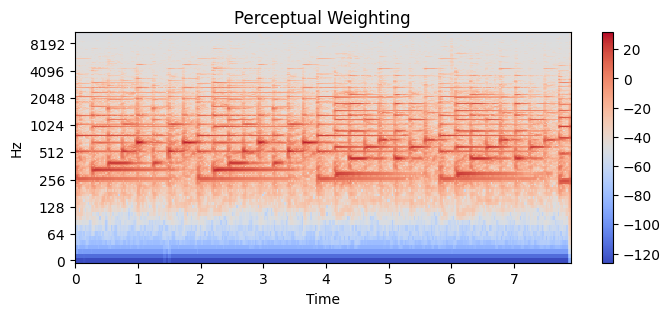

In [39]:
freqs = librosa.core.fft_frequencies(sr=sr)
Xmag = librosa.perceptual_weighting(abs(X)**2, freqs)
plt.figure(figsize=(8,3))
plt.title('Perceptual Weighting')
librosa.display.specshow(Xmag, sr=sr, x_axis='time', y_axis='log')
plt.colorbar()
plt.show()

# Longest Common Subsequence

- DTW을 유도하기 위해 고전적인 동적 프로그래밍 문제를 살펴보자: 두 문자열의 **longest common subsequence(LCS)** 를 찾는다. 하위 시퀀스(subsequence)는 원래 문자열에서 연속적인 위치를 유지하는 데 필요하지 않지만, 순서는 유지해야 한다.

In [13]:
# recursive solution
def lcs(x, y):
    if x == "" or y == "":
        return ""
    if x[0] == y[0]:
        return x[0] + lcs(x[1:], y[1:])
    else:
        z1 = lcs(x[1:], y)
        z2 = lcs(x, y[1:])
        return z1 if len(z1) > len(z2) else z2

In [14]:
pairs = [
    ('cake', 'baker'),
    ('cake', 'cape'),
    ('catcga', 'gtaccgtca'),
    ('zxzxzxmnxzmnxmznmzxnzm', 'nmnzxmxzmnzmx'),
    ('dfkjdjkfdjkjfdkfdkfjd', 'dkfjdjkfjdkjfkdjfkjdkfjdkfj'),
]

for x, y in pairs:
    print(lcs(x, y))

ake
cae
ctca
zxmxzmnzmx
dfjdjkfdjkjfdkfdkfj


- 위 재귀(recursive) 방법의 시간복잡도(time complexity)는 $O(2^{n_x+n_y})$이다. 동일한 하위 문제에 대한 솔루션을 여러 번 계산할 수 있기 때문에 속도가 느리다.

- 메모이제이션(memoization)(이전 하위 문제에 대한 솔루션을 테이블에 저장)하면 더 나아질 수 있다.
    - 셀 `(i, j)`가 길이 `lcs(x[:i], y[:j])`를 저장하는 테이블을 만든다. `i` 또는 `j`가 0, 즉 빈 문자열이면 LCS는 빈 문자열임을 알고 있다. 따라서 테이블을 모든 셀에서 0이 되도록 초기화할 수 있다. 그런 다음 왼쪽 상단에서 오른쪽 하단으로 테이블을 채운다.

In [15]:
def lcs_table(x, y):
    nx = len(x)
    ny = len(y)
    
    # Initialize a table.
    table = [[0 for _ in range(ny+1)] for _ in range(nx+1)]
    
    # Fill the table.
    for i in range(1, nx+1):
        for j in range(1, ny+1):
            if x[i-1] == y[j-1]:
                table[i][j] = 1 + table[i-1][j-1]
            else:
                table[i][j] = max(table[i-1][j], table[i][j-1])
    return table                      

In [16]:
x = 'cake'
y = 'baker'
table = lcs_table(x, y)
table

[[0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 1, 1, 1, 1],
 [0, 0, 1, 2, 2, 2],
 [0, 0, 1, 2, 3, 3]]

In [17]:
xa = ' ' + x
ya = '  ' + y
print(' '.join(ya))
for i, row in enumerate(table):
    print(xa[i], ' '.join(str(z) for z in row))

    b a k e r
  0 0 0 0 0 0
c 0 0 0 0 0 0
a 0 0 1 1 1 1
k 0 0 1 2 2 2
e 0 0 1 2 3 3


In [18]:
# backtrack

def lcs(x, y, table, i=None, j=None):
    if i is None:
        i = len(x)
    if j is None:
        j = len(y)
    if table[i][j] == 0:
        return ""
    elif x[i-1] == y[j-1]:
        return lcs(x, y, table, i-1, j-1) + x[i-1]
    elif table[i][j-1] > table[i-1][j]:
        return lcs(x, y, table, i, j-1)
    else:
        return lcs(x, y, table, i-1, j)

In [19]:
for x, y in pairs:
    table = lcs_table(x, y)
    print(lcs(x, y, table))

ake
cae
ctca
zxmxzmnzmx
dfjdjkfdjkjfdkfdkfj


- 테이블 구성에는 시간 복잡도가 $O(mn)$이고 역추적은 $O(m+n)$이다. 따라서 전체 실행 시간은 $O(mn)$이다.

출처: https://colab.research.google.com/github/stevetjoa/musicinformationretrieval.com/blob/gh-pages/lcs.ipynb#scrollTo=FQq-6QiI8wQ0